# Calculate Gene mC Fractions

In [1]:
import pandas as pd
import pybedtools

from ALLCools.mcds import MCDS

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Parameters

In [3]:
gene_meta_path = '../../../../../reference/human/GRCh38/gencode.v43.geneslop2k.tsv'
chrom_to_remove = ['chrM']

# change this to the path to your filtered metadata
metadata_path = '../results/CellMetadata.PassQC.csv.gz'

# change this to the paths to your MCDS files
mcds_path = '../../mcds/SP-HE-scNOME-MW210318.mcds/',
obs_dim = 'cell'
var_dim = 'geneslop2k'
mc_type = 'HCGN'

min_cov = 0

## Load metadata

In [4]:
gene_meta = pd.read_csv(gene_meta_path, index_col='gene_id', sep='\t')

In [5]:
gene_meta.head()

chrom  start    end    gene_name
gene_id                                           
ENSG00000290825.1  chr1   9869  16409      DDX11L2
ENSG00000223972.6  chr1  10010  15670      DDX11L1
ENSG00000227232.5  chr1  12404  31570       WASH7P
ENSG00000278267.1  chr1  15369  19436    MIR6859-1
ENSG00000243485.5  chr1  27554  33109  MIR1302-2HG

In [6]:
geneNum = gene_meta.shape[0]
print(f'Total gene number: {geneNum}')

Total gene number: 62703


In [7]:
metadata = pd.read_csv(metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 1278 cells


## Filter genes by overlap and chromosomes

In [8]:
genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
gene_bed = pybedtools.BedTool.from_dataframe(
    gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

38593 features remained


## Filter genes by cell mean coverage

Feature geneslop2k mean cov across cells added in MCDS.coords['geneslop2k_cov_mean'].
37598 features remained


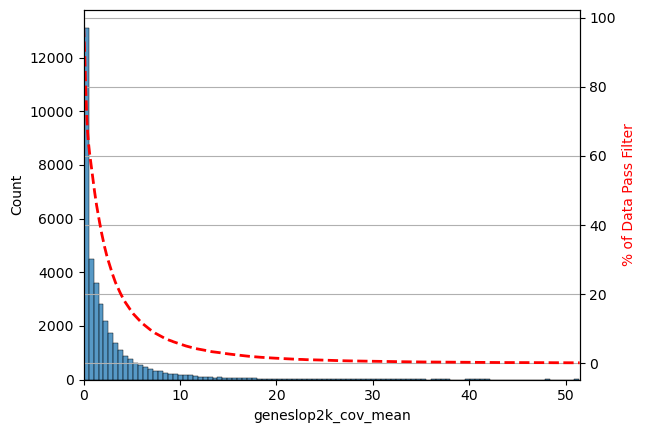

In [9]:
mcds = MCDS.open(mcds_path, 
                 var_dim=var_dim,
                 use_obs=metadata.index).sel({var_dim: use_features}).sel(mc_type = mc_type)
mcds.add_feature_cov_mean()

feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index

print(f'{use_features.size} features remained')

In [10]:
mcds = mcds.filter_feature_by_cov_mean(min_cov=min_cov)

Before cov mean filter: 38593 geneslop2k
 After cov mean filter: 37598 geneslop2k 97.4%


## Calculate and Save Gene mC Fractions

In [11]:
mcds.add_mc_frac(normalize_per_cell=True, clip_norm_value=10)

In [12]:
# only keep fraction for saving
mcds = mcds[['geneslop2k_da_frac']]
mcds['geneslop2k_da_frac'] = mcds['geneslop2k_da_frac'].astype('float32')

In [13]:
mcds.write_dataset(f'../results/geneslop2k_{mc_type}_frac.mcds', var_dims=['geneslop2k'], mode="a")

Saving geneslop2k
Saving chunk 0: 0 - 1000
Saving chunk 1: 1000 - 1278


## Save gene metadata together with gene fraction

In [14]:
results = mcds['geneslop2k_da_frac'].coords['geneslop2k_cov_mean'].to_pandas()
df = pd.DataFrame({'gene_id': results.index, 'geneslop2k_cov_mean': results.values}).set_index('gene_id')
merged_df = pd.merge(gene_meta, df, left_index=True, right_index=True)
merged_df.loc[use_features].to_csv(f'../results/GeneMetadata_{mc_type}.csv.gz')

In [16]:
mcds[['geneslop2k_da_frac']].data_vars['geneslop2k_da_frac'].to_pandas().to_csv(f'../results/geneslop2k_{mc_type}_frac_norm.csv.gz', compression='gzip')